# Baseline Notebook By:
# Achintya Kattemalavadi, Matthew Frank, Saranya Mylswami

# **HMS - Harmful Brain Activity Classification**
Classify seizures and other patterns of harmful brain activity in critically ill patients.  
https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification

## Overview
The aim of our project is to detect and classify seizures and other types of harmful brain activity. We will develop a model trained on electroencephalography (EEG) signals from critically ill hospital patients ([link to the Kaggle competition](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification)).

This work may help improve EEG pattern classification accuracy, unlocking transformative benefits for neurocritical care, epilepsy, and drug development. Advancements in this area may allow doctors and brain researchers to detect seizures or other brain damage to provide faster and more accurate treatments.

# Preparing for EDA and baselining

### Importing relevant libraries

In [4]:
# Imports
import os
import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras_cv
import glob

from random import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.notebook import tqdm
import joblib

### Settings for memory, GPU vs. CPU, and logging in Tensorflow

In [5]:
# Logging to tell which device is being used
# NOTE: set to false to reduce output
tf.debugging.set_log_device_placement(False)

# Maximum GPU memory to use in MB
# NOTE: change for your system
MAX_GPU_MEM_MB = 6144

# Identifying GPUs and setting max memory to be used by tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f"Identified GPUs on system: {gpus}")
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MAX_GPU_MEM_MB)])
    print(f"Limited GPU memory to {MAX_GPU_MEM_MB}")
  except RuntimeError as e:
    print(e)

Identified GPUs on system: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Limited GPU memory to 6144


## **Overview of Columns**
- **eeg_id, eeg_sub_id, eeg_label_offset_seconds:** Identifiers and timing information for EEG recordings.
- **spectrogram_id, spectrogram_sub_id, spectrogram_label_offset_seconds:** Identifiers and timing information related to spectrogram representations of the EEG data.
- **label_id, patient_id:** Unique identifiers for the label and patient.
- **expert_consensus:** The classification of the brain activity by experts (your target variable).
- **seizure_vote, lpd_vote, gpd_vote, lrda_vote, grda_vote, other_vote:** Votes or assessments from different experts or algorithms regarding the presence and type of brain activity.

## NOTES:
 - The spectrogram supplements, but does not substitute for, review of the raw EEG . Because spectrograms compress EEG data and display long periods of time on a single screen, very brief seizures may not result in an identifiable change.
 - EEG signals are one of the most basic methods used in identifying and analyzing brain activities.
 - Visual representation of EEG signals can be achieved with spectrograms. Spectrograms represent a visual representation of a signal's signal strength over time.

## Load Data

In [6]:
# Dataset directories
# NOTE: make sure to change these based on where the data is stored
BASE_PATH = "../hms-harmful-brain-activity-classification"
TRAIN_EEG_PATH = os.path.join(BASE_PATH, "train_eegs", "")
TRAIN_SPECT_PATH = os.path.join(BASE_PATH, "train_spectrograms", "")
TEST_EEG_PATH = os.path.join(BASE_PATH, "test_eegs", "")
TEST_SPECT_PATH = os.path.join(BASE_PATH, "test_spectrograms", "")

# Reading the CSV for train and test set labels from the competition
df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(BASE_PATH, "test.csv"))

# Showing the head and size of the training dataset to check if it loaded properly
display(df.head())
print(f"Training labels dataframe shape: {df.shape}")

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   
2       42516          Seizure             3         0         0          0   
3       42516          Seizure             3         0         0          0   
4       42516          Seizure             3         0         0          0   

   grda_vote  other_vote  
0          0           0  
1          0           0  
2          0           0  
3          0           0  
4          0           0

Training labels dataframe shape: (106800, 15)


# Initial EDA to understand the dataset

### Get division of each expert consensus (label) in the dataset

In [7]:
# Normalized counts of labels
print(df["expert_consensus"].value_counts(normalize=True))

expert_consensus
Seizure    0.196002
GRDA       0.176601
Other      0.176105
GPD        0.156386
LRDA       0.155805
LPD        0.139101
Name: proportion, dtype: float64


Based on the above, it seems like examples labeled as "Seizure" are more common at around 19.6% of the training dataset, while examples labeled "LPD" are less common, at around 13.9% of the dataset.

This doesn't seem like a major imbalance, and the other output classes fall pretty evenly in proportion of training data between these two percentages. However, on creating a baseline model, we can understand better if this imbalance leads to issues with consistent majority class selection, or weaknesses in identifying specific classes.

### Read one of the training spectrograms and a corresponding EEG

In [8]:
# ID of a random training spectrogram
eda_train_spect_id = df['spectrogram_id'].iloc[randint(0, df.shape[0] - 1)]
print(f"Looking at spectrogram of ID {eda_train_spect_id}, rows in label data:")

# Print the rows of df corresponding to the spectrogram
# This will help us see the relationship between spectrograms, labels, and eegs
eda_train_spect_rows = df.loc[df["spectrogram_id"] == eda_train_spect_id]
display(eda_train_spect_rows.head(5))

# Get the ID of a training EEG corresponding to the sample
eda_train_eeg_id = eda_train_spect_rows['eeg_id'].iloc[randint(0, eda_train_spect_rows.shape[0] - 1)]
print(f"Will look at EEG of ID {eda_train_eeg_id} which correspondes to the spectrogram {eda_train_spect_id}")

# Read parquet for one spectrogram file and a corresponding eeg file into dfs
eda_spect_df = pd.read_parquet(os.path.join(TRAIN_SPECT_PATH, f"{eda_train_spect_id}.parquet"))
eda_eeg_df = pd.read_parquet(os.path.join(TRAIN_EEG_PATH, f"{eda_train_eeg_id}.parquet"))

# Print the first five rows of each
print(f"Spectrogram data for ID {eda_train_spect_id}:")
display(eda_spect_df.head(5))
print(f"EEG data for ID {eda_train_eeg_id}:")
display(eda_eeg_df.head(5))

# Print a list of the column names
eda_spect_df_cols = list(eda_spect_df.columns)
eda_eeg_df_cols = list(eda_eeg_df.columns)
print(f"Spectrogram data columns: {eda_spect_df_cols}")
print(f"EEG data columns: {list(eda_eeg_df_cols)}")

Looking at spectrogram of ID 1722272591, rows in label data:


eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
84206  1542611461           0                       0.0      1722272591   
84207  1542611461           1                       2.0      1722272591   
84208  1542611461           2                       4.0      1722272591   
84209  1542611461           3                      14.0      1722272591   
84210  1542611461           4                      16.0      1722272591   

       spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
84206                   0                               0.0   238458380   
84207                   1                               2.0  2218112501   
84208                   2                               4.0  1523190717   
84209                   3                              14.0  3065306806   
84210                   4                              16.0   545597384   

       patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
84206       54199              GPD             0         0         3   
84207       54199              GPD             0         0         3   
84208       54199              GPD             0         0         3   
84209       54199              GPD             0         0         3   
84210       54199              GPD             0         0         3   

       lrda_vote  grda_vote  other_vote  
84206          0          0           0  
84207          0          0           0  
84208          0          0           0  
84209          0          0           0  
84210          0          0           0

Will look at EEG of ID 1542611461 which correspondes to the spectrogram 1722272591
Spectrogram data for ID 1722272591:


time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37  LL_1.56  LL_1.76  \
0     1     0.28     1.80     1.98     2.93     3.60     2.18     2.12   
1     3     1.02     1.67     4.35     4.44     4.88     4.82     2.87   
2     5     0.62     0.77     1.69     2.61     3.42     3.31     3.70   
3     7     0.16     1.17     1.51     2.54     3.57     3.00     2.55   
4     9     0.28     1.02     1.85     1.86     4.30     4.94     3.77   

   LL_1.95  LL_2.15  ...  RP_18.16  RP_18.36  RP_18.55  RP_18.75  RP_18.95  \
0     2.08     2.11  ...      0.13      0.11      0.11      0.10      0.10   
1     3.10     3.88  ...      0.08      0.09      0.12      0.11      0.11   
2     3.40     2.80  ...      0.08      0.17      0.15      0.16      0.20   
3     2.57     1.25  ...      0.04      0.06      0.07      0.09      0.11   
4     5.27     4.23  ...      0.07      0.06      0.05      0.05      0.05   

   RP_19.14  RP_19.34  RP_19.53  RP_19.73  RP_19.92  
0      0.09      0.09      0.10      0.09      0.09  
1      0.11      0.13      0.13      0.10      0.10  
2      0.16      0.09      0.11      0.13      0.08  
3      0.08      0.07      0.07      0.10      0.07  
4      0.05      0.06      0.06      0.06      0.06  

[5 rows x 401 columns]

EEG data for ID 1542611461:


Fp1         F3         C3         P3         F7     T3     T5  \
0 -42.270000 -26.320000  21.000000 -20.740000 -26.580000 -13.03  14.36   
1 -80.809998 -51.840000 -90.389999 -36.950001 -41.740002  -3.19  -3.19   
2 -60.080002 -32.169998 -12.760000 -23.129999 -28.709999 -10.10   9.30   
3 -35.360001 -20.740000  45.189999 -18.080000 -23.930000 -18.34  14.62   
4 -70.709999 -47.049999 -67.260002 -36.419998 -39.080002  -6.65  -1.60   

          O1         Fz         Cz         Pz        Fp2         F4    C4  \
0 -20.469999  29.770000 -16.480000  34.820000  -2.390000 -14.620000  5.32   
1 -41.200001 -30.309999 -87.989998 -95.169998 -54.230000 -26.850000  5.32   
2 -32.700001  11.960000 -33.230000  -6.110000 -22.059999 -15.150000  8.51   
3 -20.200001  43.599998   0.000000  64.599998   8.770000 -10.630000  5.85   
4 -37.480000 -17.280001 -74.430000 -66.459999 -41.740002 -24.190001  4.25   

           P4         F8     T4         T6         O2        EKG  
0   81.879997  57.950001 -22.33 -25.790001 -58.480000  25.520000  
1  -30.309999 -35.619999 -11.43 -17.549999 -96.230003  27.639999  
2   51.040001  27.120001 -15.15 -21.530001 -61.939999  -0.800000  
3  110.589996  81.610001 -23.66 -27.650000 -47.049999  15.150000  
4   -6.110000 -15.150000 -15.15 -19.940001 -89.059998  32.160000

Spectrogram data columns: ['time', 'LL_0.59', 'LL_0.78', 'LL_0.98', 'LL_1.17', 'LL_1.37', 'LL_1.56', 'LL_1.76', 'LL_1.95', 'LL_2.15', 'LL_2.34', 'LL_2.54', 'LL_2.73', 'LL_2.93', 'LL_3.13', 'LL_3.32', 'LL_3.52', 'LL_3.71', 'LL_3.91', 'LL_4.1', 'LL_4.3', 'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08', 'LL_5.27', 'LL_5.47', 'LL_5.66', 'LL_5.86', 'LL_6.05', 'LL_6.25', 'LL_6.45', 'LL_6.64', 'LL_6.84', 'LL_7.03', 'LL_7.23', 'LL_7.42', 'LL_7.62', 'LL_7.81', 'LL_8.01', 'LL_8.2', 'LL_8.4', 'LL_8.59', 'LL_8.79', 'LL_8.98', 'LL_9.18', 'LL_9.38', 'LL_9.57', 'LL_9.77', 'LL_9.96', 'LL_10.16', 'LL_10.35', 'LL_10.55', 'LL_10.74', 'LL_10.94', 'LL_11.13', 'LL_11.33', 'LL_11.52', 'LL_11.72', 'LL_11.91', 'LL_12.11', 'LL_12.3', 'LL_12.5', 'LL_12.7', 'LL_12.89', 'LL_13.09', 'LL_13.28', 'LL_13.48', 'LL_13.67', 'LL_13.87', 'LL_14.06', 'LL_14.26', 'LL_14.45', 'LL_14.65', 'LL_14.84', 'LL_15.04', 'LL_15.23', 'LL_15.43', 'LL_15.63', 'LL_15.82', 'LL_16.02', 'LL_16.21', 'LL_16.41', 'LL_16.6', 'LL_16.8', 'LL_16.99', 'LL

The spectrograms are derived from the EEG data, with offsets happening at a period of a few seconds. Then, each of these are classed based on an expert consensus vote.

### Plot the frequency bands in the example spectrogram

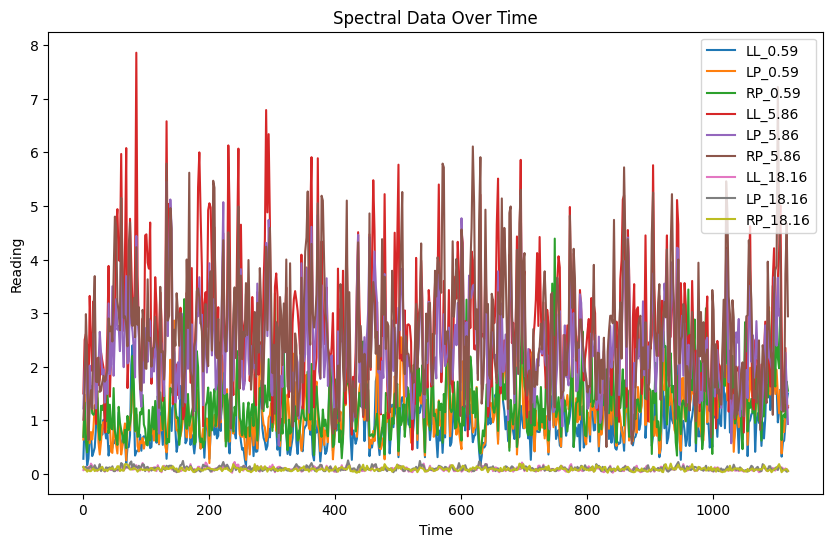

In [9]:
plt.figure(figsize=(10, 6))

# Plot a few of the location bands at a several frequencies
plt.plot(eda_spect_df['time'], eda_spect_df['LL_0.59'], label='LL_0.59')
plt.plot(eda_spect_df['time'], eda_spect_df['LP_0.59'], label='LP_0.59')
plt.plot(eda_spect_df['time'], eda_spect_df['RP_0.59'], label='RP_0.59')
plt.plot(eda_spect_df['time'], eda_spect_df['LL_5.86'], label='LL_5.86')
plt.plot(eda_spect_df['time'], eda_spect_df['LP_5.86'], label='LP_5.86')
plt.plot(eda_spect_df['time'], eda_spect_df['RP_5.86'], label='RP_5.86')
plt.plot(eda_spect_df['time'], eda_spect_df['LL_18.16'], label='LL_18.16')
plt.plot(eda_spect_df['time'], eda_spect_df['LP_18.16'], label='LP_18.16')
plt.plot(eda_spect_df['time'], eda_spect_df['RP_18.16'], label='RP_18.16')

# Adding labels and legend
plt.xlabel('Time')
plt.ylabel('Reading')
plt.title('Spectral Data Over Time')
plt.legend()

plt.show()

There seems to be a large difference between the maximum and minimum values for each frequency/location in the spectrogram data.

### Plot heatmap of the example spectrogram to try and reconstruct the example figures in the dataset

Max reading in spectrogram: 1119.0


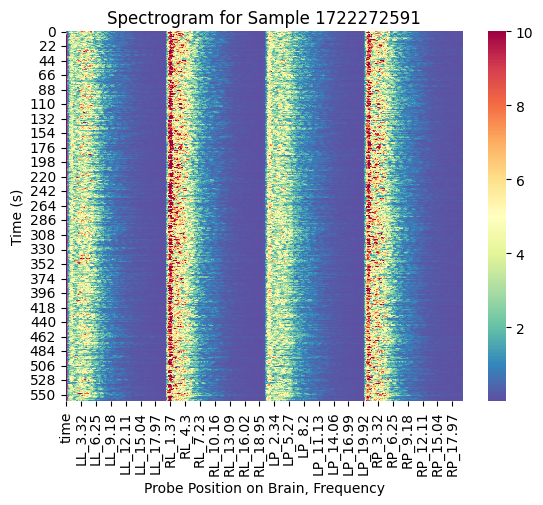

In [10]:
# Create the heatmap
# NOTE: setting vmax low due to the difference highlighted above
plt.figure()
ax = sns.heatmap(eda_spect_df, vmax=10, cmap=sns.color_palette("Spectral_r", as_cmap=True))

# Add a title to the plot
ax.set_title(f"Spectrogram for Sample {eda_train_spect_id}")

# Set X and Y axis labels
ax.set(
    xlabel="Probe Position on Brain, Frequency",
    ylabel="Time (s)"
)

# Print the max value
print(f"Max reading in spectrogram: {eda_spect_df.max(axis=None)}")

From what we can see here, the data in each spectrogram file has columns representing different probe positions related to the brain layout, as well as the frequency band at which measurements were being taken.

## **HMS-HBAC: KerasCV Starter Notebook**

The baseline work below is inspired by the starter notebook created by KerasCV for the competition:

https://www.kaggle.com/code/awsaf49/hms-hbac-kerascv-starter-notebook

## Configuration
- **Verbosity (`verbose = 1`):** This setting governs the granularity of feedback provided during the model's training, enabling a detailed view of its learning trajectory and the obstacles it encounters.
- **Seeds of Consistency (`seed = 42`):** This property allows for the consistent replication of our experiments, facilitating the validation of our methodologies and findings.
- **Architectural Blueprint (`preset = "efficientnetv2_b2_imagenet"`):** The strategic choice of EfficientNetV2_B2, pre-trained on ImageNet, capitalizes on the insights from ImageNet in tailoring them to the task of classifying brain activities. It abbreviates the model's learning curve while amplifying its performance.
- **The Canvas (`image_size = [400, 300]`):** Setting the dimensions of our input data ensure the retention of essential details within the EEG spectrograms without imposing undue computational burdens.
- **The Marathon (`epochs = 13`):** An epoch setting of 13 allows the model to refine its insights with each dataset iteration progressively.
- **The Pace (`batch_size = 4`):** The chosen batch size dictates the rate at which our model assimilates information. A modest batch size facilitates a more discerning learning process, enabling frequent weight adjustments based on comprehensive feedback from various examples.
- **Navigating the Learning Curve (`lr_mode = "cos"`):** Adopting a cosine-based learning rate scheduler reflects the fluid dynamics of learning, characterized by robust initial adjustments followed by finer tuning. This approach ensures the meticulous calibration of the model's parameters as it converges towards optimal performance.
- **Striving for Perfection (`drop_remainder = True`):** This policy underscores our preference for uniformity and thoroughness in the training data, guaranteeing that a complete dataset informs each learning iteration.
- **A Spectrum of Understanding (`num_classes = 6`):** The delineation of the classification task into six distinct categories mirrors the diverse spectrum of brain activity. This detailed segmentation empowers our model to cultivate a nuanced comprehension of the varied signals it analyzes.
- **The Crossroads (`fold = 0`):** Implementing cross-validation folds symbolizes exploring multiple evaluative pathways. Initiating this exploration with fold 0 ensures a comprehensive assessment of the model's efficacy across heterogeneous data segments.
- **Naming the Unseen (`class_names` and `label2name`):** These labels represent the categories of brain dynamics we aim to decipher, thereby bridging the divide between quantitative data and qualitative understanding.

In [11]:
# Configuration for classifiers
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [400, 300]  # Input image size
    epochs = 1000 # Training epochs
    batch_size = 32  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
    label2name = dict(enumerate(class_names))
    name2label = {v:k for k, v in label2name.items()}

## Dataset Path and Preparation

### Structuring the Data Repository
The initial step involves establishing a `BASE_PATH`. This folder acts as a central hub for organizing and finding all the data in our extensive dataset. Having this structured setup makes it easier and faster to work with the data.


### Preparation for Training and Validation
We carefully segment the data into sections for training and validation, ensuring that each piece helps the model learn effectively. We create a detailed framework by linking EEG and spectrogram data paths to their respective records. This framework allows us access to essential data for training the model but also guides us in understanding brain activity better.

In [12]:
BASE_PATH = "../hms-harmful-brain-activity-classification"

# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['eeg_path'] = f'{BASE_PATH}/train_eegs/'+df['eeg_id'].astype(str)+'.parquet'
df['spec_path'] = f'{BASE_PATH}/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.parquet'
df['spec2_path'] = f'{BASE_PATH}/SPEC_DIR/train_spectrograms/'+df['spectrogram_id'].astype(str)+'.npy'
df['class_name'] = df.expert_consensus.copy()
df['class_label'] = df.expert_consensus.map(CFG.name2label)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['eeg_path'] = f'{BASE_PATH}/test_eegs/'+test_df['eeg_id'].astype(str)+'.parquet'
test_df['spec_path'] = f'{BASE_PATH}/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.parquet'
test_df['spec2_path'] = f'{BASE_PATH}/SPEC_DIR/test_spectrograms/'+test_df['spectrogram_id'].astype(str)+'.npy'
display(test_df.head(2))

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   

   patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  lrda_vote  \
0       42516          Seizure             3         0         0          0   
1       42516          Seizure             3         0         0          0   

   grda_vote  other_vote                                           eeg_path  \
0          0           0  ../hms-harmful-brain-activity-classification/t...   
1          0           0  ../hms-harmful-brain-activity-classification/t...   

                                           spec_path  \
0  ../hms-harmful-brain-activity-classification/t...   
1  ../hms-harmful-brain-activity-classification/t...   

                                          spec2_path class_name  class_label  
0  ../hms-harmful-brain-activity-classification/S...    Seizure            0  
1  ../hms-harmful-brain-activity-classification/S...    Seizure            0

spectrogram_id      eeg_id  patient_id  \
0          853520  3911565283        6885   

                                            eeg_path  \
0  ../hms-harmful-brain-activity-classification/t...   

                                           spec_path  \
0  ../hms-harmful-brain-activity-classification/t...   

                                          spec2_path  
0  ../hms-harmful-brain-activity-classification/S...

## Conversion of Parquet to NPY Format

To streamline our data handling and improve how quickly we load data, we've changed the EEG spectrogram file format from Parquet to NPY (NumPy). This shift helps us optimize our data pipeline, making accessing and working with spectrogram data more accessible and faster. It's important to emphasize that this change only affects how the data is stored; the actual content and quality of the spectrograms stay the same, ensuring the integrity of our dataset.

In [13]:
# Define a function to process a single eeg_id
SPEC_DIR = BASE_PATH + "/SPEC_DIR"

if not os.path.exists(SPEC_DIR):
    os.makedirs(SPEC_DIR, exist_ok=True)

def process_spec(spec_id, split="train"):
    # Ensure the subdirectory exists
    spec_dir_path = f"{SPEC_DIR}/{split}_spectrograms"
    if not os.path.exists(spec_dir_path):
        os.makedirs(spec_dir_path, exist_ok=True)
    
    # Process the spectrogram
    spec_path = f"{BASE_PATH}/{split}_spectrograms/{spec_id}.parquet"
    spec = pd.read_parquet(spec_path)
    spec = spec.fillna(0).values[:, 1:].T  # fill NaN values with 0, transpose for (Freq, Time)
    spec = spec.astype("float32")
    
    # Save the processed spectrogram
    np.save(f"{spec_dir_path}/{spec_id}.npy", spec)

# Example usage with df
spec_ids = df["spectrogram_id"].unique()
test_spec_ids = test_df["spectrogram_id"].unique()

# NOTE: uncomment when re-creating NPYs
# for spec_id in tqdm(spec_ids):
#    process_spec(spec_id, split="train")

# for spec_id in tqdm(test_spec_ids):
#    process_spec(spec_id, split="test")


## Construction of the Data Loader

Creating an effective and adaptable data loader is crucial for training deep learning models, especially in medical imaging and signal processing fields. Our approach includes several aspects to make it easier to load EEG spectrogram data while also integrating dynamic data augmentation techniques. This approach exposes our model to various data presentations, improving its ability to generalize and handle different scenarios. Here, we'll explain how our data loader works, covering aspects like data decoding, augmentation, and batching strategies, all aimed at making the model training process more efficient. For the baseline, we'll keep the augmentation turned off.

In [14]:
def build_augmenter(dim=CFG.image_size):
    augmenters = [
        keras_cv.layers.MixUp(alpha=2.0),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.1)), # freq-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # time-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.5:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size, dtype=32):
    def decode_signal(path, offset=None):
        # Read .npy files and process the signal
        # Using tf to load is because its prob faster
        file_bytes = tf.io.read_file(path)
        sig = tf.io.decode_raw(file_bytes, tf.float32)
        sig = sig[1024//dtype:]  # Remove header tag
        sig = tf.reshape(sig, [400, -1])
        
        # Extract labeled subsample from full spectrogram using "offset"
        if offset is not None: 
            offset = offset // 2  # Only odd values are given
            sig = sig[:, offset:offset+300]
            
            # Pad spectrogram to ensure the same input shape of [400, 300]
            pad_size = tf.math.maximum(0, 300 - tf.shape(sig)[1])
            sig = tf.pad(sig, [[0, 0], [0, pad_size]])
            sig = tf.reshape(sig, [400, 300])
        
        # Log spectrogram 
        sig = tf.clip_by_value(sig, tf.math.exp(-4.0), tf.math.exp(8.0)) # avoid 0 in log
        sig = tf.math.log(sig)
        
        # Normalize spectrogram
        sig -= tf.math.reduce_mean(sig)
        sig /= tf.math.reduce_std(sig) + 1e-6
        
        # Mono channel to 3 channels to use "ImageNet" weights
        sig = tf.tile(sig[..., None], [1, 1, 3])
        return sig
    
    def decode_label(label):
        label = tf.one_hot(label, CFG.num_classes)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.num_classes])
        return label
    
    def decode_with_labels(path, offset=None, label=None):
        sig = decode_signal(path, offset)
        label = decode_label(label)
        return (sig, label)
    
    return decode_with_labels if with_labels else decode_signal


def build_dataset(paths, offsets=None, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=False, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths, offsets) if labels is None else (paths, offsets, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Data Split Strategy

We've implemented a detailed data-splitting strategy to ensure our model's evaluation is reliable and trustworthy. Here's how it works:

- **Multiple Buckets:** We've divided our dataset into five folds, creating distinct buckets. By doing this, we can perform comprehensive cross-validation with `n_splits=5`.
- **Rotating Validation Sets:** We're using a rotating scheme for validation sets. Each bucket takes turns being the validation set, while the rest combine to form the training set. This way, every data point gets used for training and validation throughout the cross-validation process.
- **Multiple Evaluations:** Our model undergoes training and evaluation multiple times, each time with different subsets of data. This repetition helps us assess its performance more accurately and robustly.

Using this stratified group k-fold cross-validation approach, we ensure that class labels are evenly distributed within each fold. Also, it prevents any patient's data from being split between training and validation sets, maintaining the model's ability to generalize and avoiding information leakage.


In [15]:
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(sgkf.split(df, y=df["class_label"], groups=df["patient_id"])):
    df.loc[valid_idx, "fold"] = fold


df.groupby(["fold", "class_name"])[["eeg_id"]].count().T

fold           0                                     1                    ...  \
class_name   GPD  GRDA   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA  ...   
eeg_id      2050  2605  1168  3793  3462    4007  4832  4856  4463  3117  ...   

fold           3                         4                                  
class_name   LPD  LRDA Other Seizure   GPD  GRDA   LPD  LRDA Other Seizure  
eeg_id      2318  4296  3884    4787  1889  3700  4249  3002  4013    4045  

[1 rows x 30 columns]

## Constructing the Training and Validation Datasets

Preparing our dataset for model training and evaluation is critical to our project. It ensures that our model gets exposed to a wide range of data scenarios during training and provides a strong foundation for assessing its performance on new data. We have two approaches to consider:

- **Sampling from the Full Dataset:** Initially, we could sample a single instance from each unique spectrogram_id to create a more balanced or manageable dataset. It involves grouping the DataFrame by `spectrogram_id`, selecting the first entry from each group, and then splitting these samples into training and validation sets based on the fold assignment.
  
- **Utilizing the Entire Dataset:** Alternatively, the entire dataset for training and validation allows us to make the most of all available data. It is beneficial for complex tasks like ours, where the diversity and volume of data can significantly impact model performance.

We're adopting the second approach for our project, using the entire dataset while splitting it into training and validation sets based on predefined fold assignments. It ensures that each fold serves as a validation set in sequence, giving our model exposure to diverse data configurations and enhancing the validity of our evaluation metrics.

In [16]:
# Sample from full data
# df.groupby("spectrogram_id"): This groups the DataFrame df by unique values in the column "spectrogram_id". 
# Each group corresponds to all rows in df that have the same spectrogram ID.
#sample_df = df.groupby("spectrogram_id").head(1).reset_index(drop=True)
#train_df = sample_df[sample_df.fold != CFG.fold]
#valid_df = sample_df[sample_df.fold == CFG.fold]

# Or we can train on whole dataset
train_df = df[df.fold != CFG.fold]
valid_df = df[df.fold == CFG.fold]

# Display number of samples
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=False, cache=False)
# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

# Num Train: 89715 | Num Valid: 17085


2024-04-19 18:40:17.304464: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-19 18:40:17.304493: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-19 18:40:17.304504: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-19 18:40:17.304724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-19 18:40:17.304765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## New Way to Load data...

In [17]:
# Desired sizes of your datasets
train_size = 10000
valid_size = 5000
test_size = 5000

#train_size = 75000
#valid_size = 10000
#test_size = 10000

# Initialize lists to hold data for each set
train_data = []
valid_data = []
test_data = []

# Number of classes
num_classes = df['class_label'].nunique()

# Calculate samples per class for each dataset
samples_per_class_train = train_size // num_classes
samples_per_class_valid = valid_size // num_classes
samples_per_class_test = test_size // num_classes

# For reproducibility
np.random.seed(CFG.seed)

# Split and sample
for _, group in df.groupby('class_label'):
    # Shuffle the group to randomize selection
    group = group.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
    
    # Append data for train
    train_data.append(group.iloc[:samples_per_class_train])
    
    # Update index for valid
    valid_start_idx = samples_per_class_train
    valid_end_idx = valid_start_idx + samples_per_class_valid
    valid_data.append(group.iloc[valid_start_idx:valid_end_idx])
    
    # Update index for test
    test_start_idx = valid_end_idx
    test_end_idx = test_start_idx + samples_per_class_test
    test_data.append(group.iloc[test_start_idx:test_end_idx])

# Concatenate lists into DataFrames
train_df = pd.concat(train_data).sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
valid_df = pd.concat(valid_data).sample(frac=1, random_state=CFG.seed).reset_index(drop=True)
test_df = pd.concat(test_data).sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

print("Training Data Class Distribution:")
print(train_df['class_label'].value_counts())

print("\nValidation Data Class Distribution:")
print(valid_df['class_label'].value_counts())

print("\nTest Data Class Distribution:")
print(test_df['class_label'].value_counts())


# Display number of samples in each set
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)} | Num Test: {len(test_df)}")

# Train
train_paths = train_df.spec2_path.values
train_offsets = train_df.spectrogram_label_offset_seconds.values.astype(int)
train_labels = train_df.class_label.values
train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=1024, augment=False, cache=True, cache_dir='cache_train/')
# Valid
valid_paths = valid_df.spec2_path.values
valid_offsets = valid_df.spectrogram_label_offset_seconds.values.astype(int)
valid_labels = valid_df.class_label.values
valid_ds = build_dataset(valid_paths, valid_offsets, valid_labels, batch_size=CFG.batch_size,
                         repeat=True, shuffle=False, augment=False, cache=True, cache_dir='cache_valid/')

# Test
test_paths = test_df.spec2_path.values
test_offsets = test_df.spectrogram_label_offset_seconds.values.astype(int)
test_labels = test_df.class_label.values
test_ds = build_dataset(test_paths, test_offsets, test_labels, batch_size=CFG.batch_size,
                        repeat=True, shuffle=False, augment=False, cache=True, cache_dir='cache_test/')

# For Neural Network training
num_train_samples = len(train_df)
num_valid_samples = len(valid_df)
num_test_samples = len(test_df)

train_steps = math.ceil(num_train_samples / CFG.batch_size)
valid_steps = math.ceil(num_valid_samples / CFG.batch_size)
test_steps = math.ceil(num_test_samples / CFG.batch_size)

Training Data Class Distribution:
class_label
0    1666
2    1666
5    1666
3    1666
1    1666
4    1666
Name: count, dtype: int64

Validation Data Class Distribution:
class_label
0    833
2    833
3    833
5    833
1    833
4    833
Name: count, dtype: int64

Test Data Class Distribution:
class_label
0    833
2    833
3    833
5    833
1    833
4    833
Name: count, dtype: int64
# Num Train: 9996 | Num Valid: 4998 | Num Test: 4998


## Dataset Visualization

At the outset of any data-driven project, a fundamental step involves thoroughly examining and visualizing the dataset. This initial exploration not only aids in comprehending the dataset's structure and characteristics but also serves as a litmus test for the effectiveness of preprocessing and augmentation techniques. By visually inspecting samples from the dataset, we can gain insights into the diversity and distribution of data across different categories, ensuring that our model is trained on a representative and well-balanced dataset.

In the context of our project, our objective is to visualize a subset of EEG spectrogram data, specifically focusing on showcasing several examples from each class. This visual representation highlights the variability within each class and validates the functionality of our data loading and augmentation pipeline. The process involves:

* Systematically iterating over batches of the training dataset.
* Selecting a predetermined number of examples from each class.
* Arrange them in a grid format for visualization.

Such a visual inspection is invaluable for proactively identifying potential issues early in the model development phase.


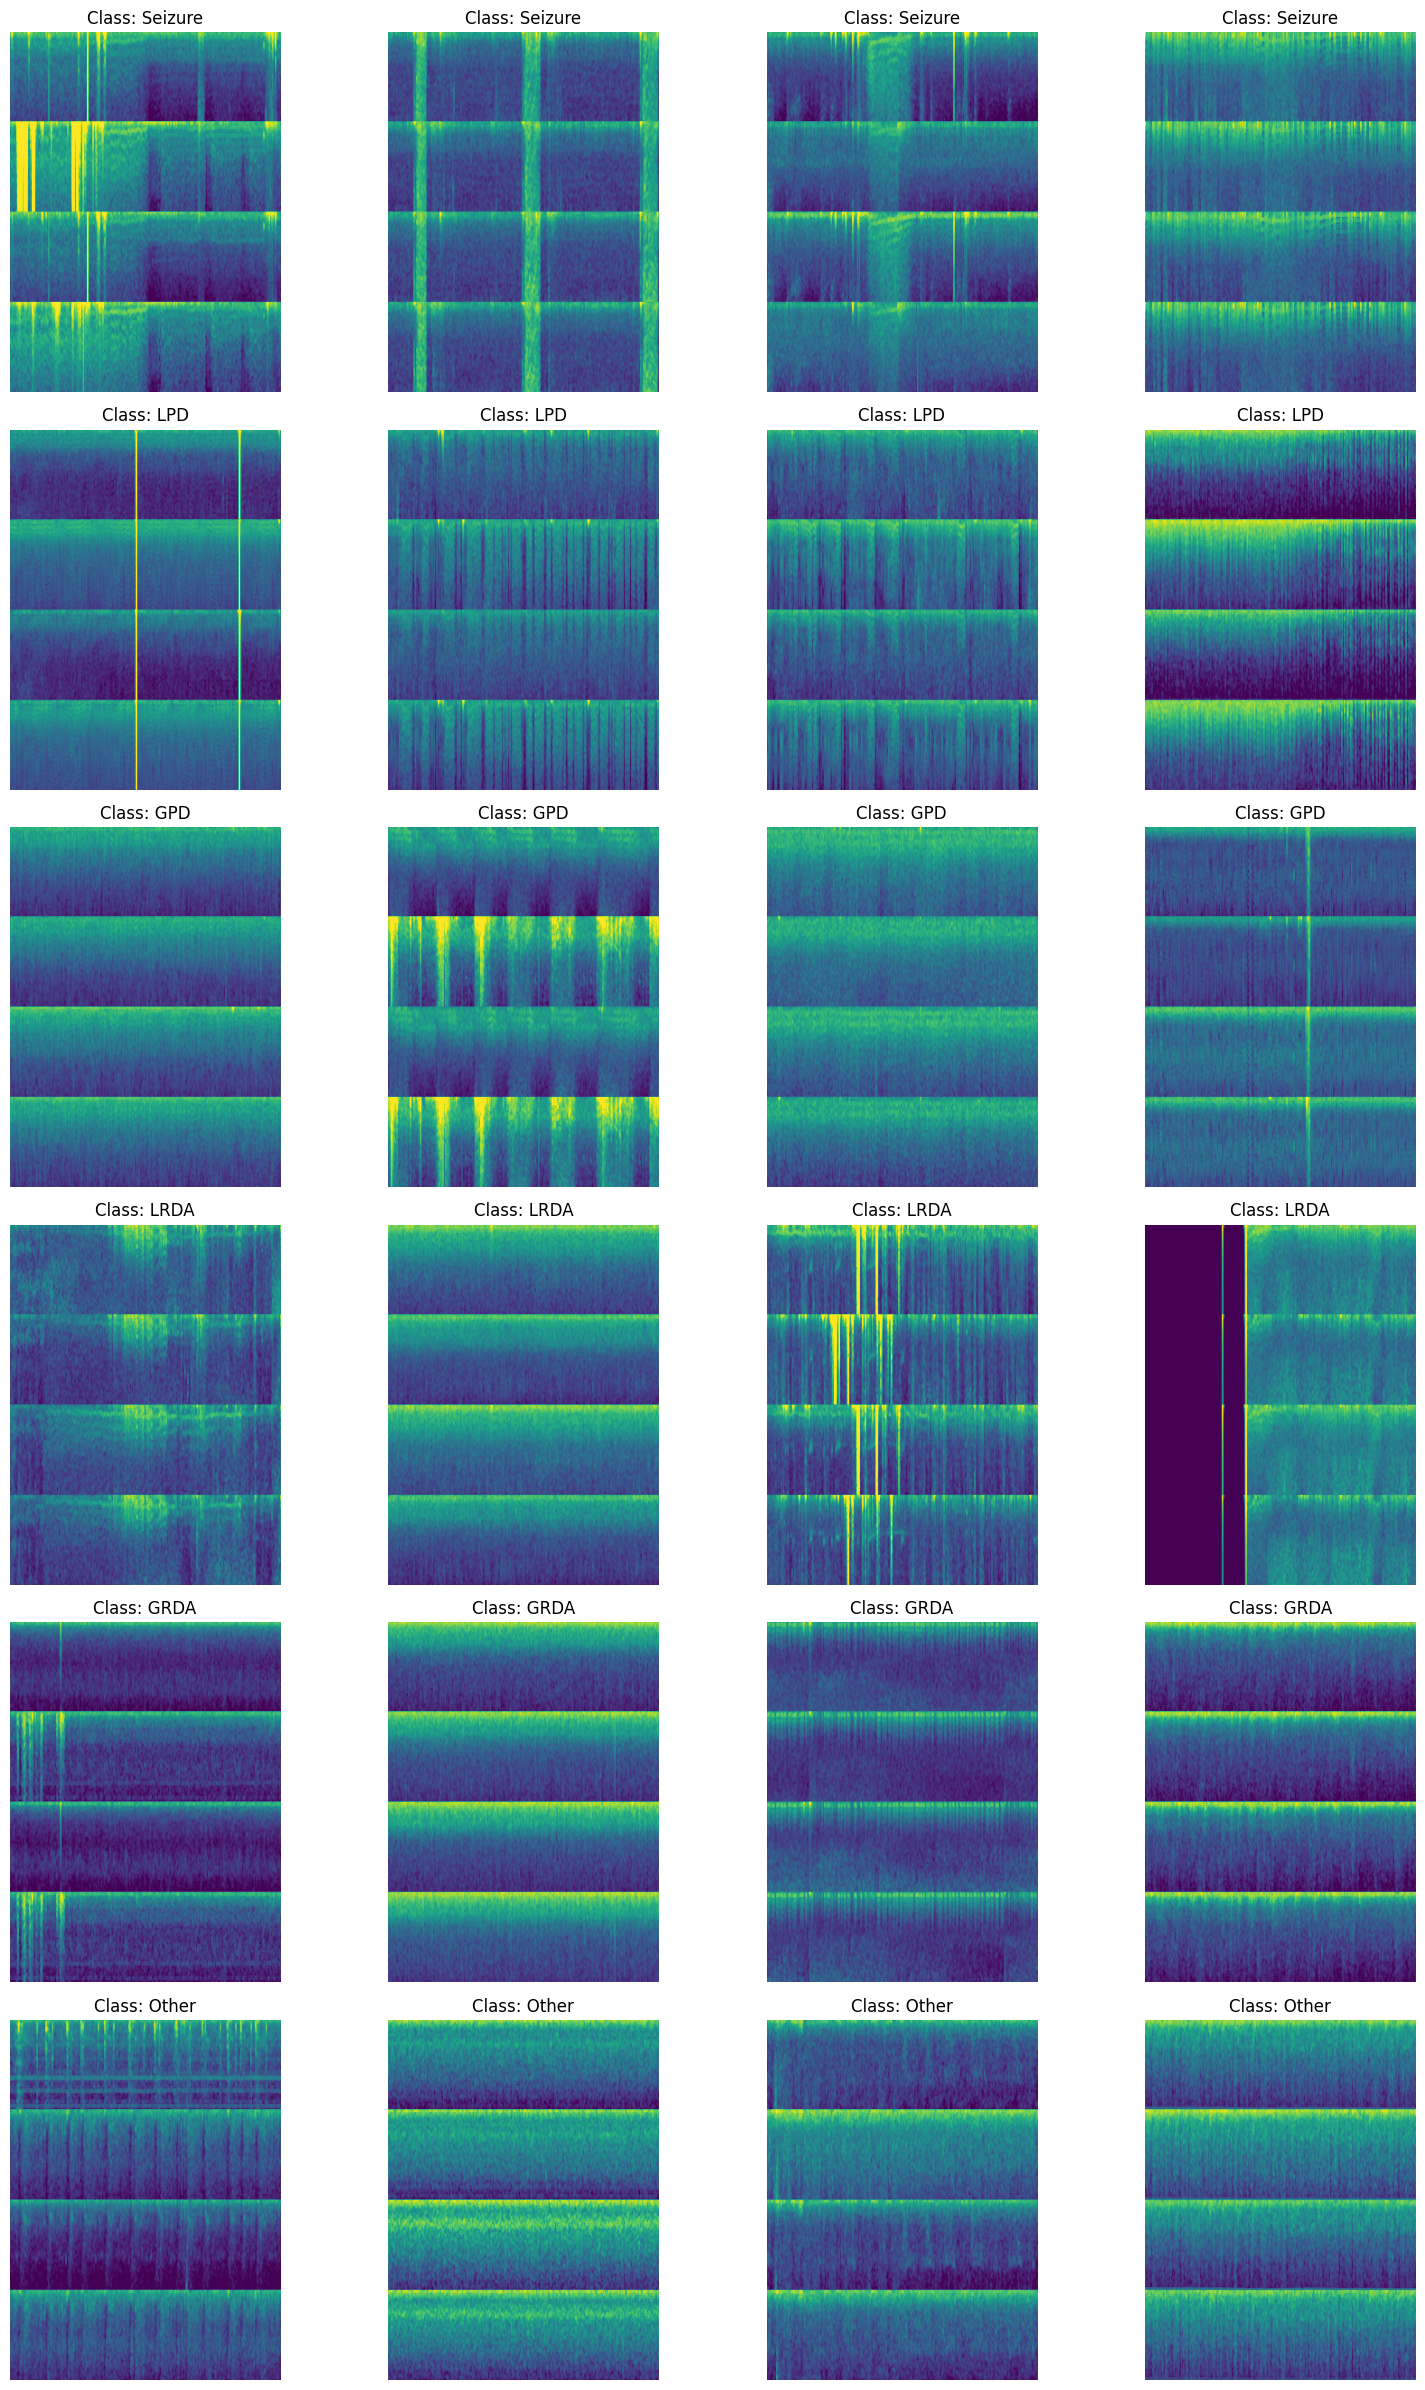

In [18]:
# Initialize a structure to hold examples
examples_per_class = {label: [] for label in range(CFG.num_classes)}

# Iterate over batches in the dataset
for imgs, tars in train_ds.take(100):  # Limiting to first 100 batches for efficiency
    for img, tar in zip(imgs.numpy(), tars.numpy()):
        label = np.argmax(tar)
        # Collect up to 4 examples per class
        if len(examples_per_class[label]) < 4:
            examples_per_class[label].append((img, tar))
        # Check if we have collected 4 examples for all classes
        if all(len(examples) == 4 for examples in examples_per_class.values()):
            break
    if all(len(examples) == 4 for examples in examples_per_class.values()):
        break


num_classes = len(examples_per_class)
num_examples_per_class = 4 
num_imgs = num_classes * num_examples_per_class

# Calculate the grid size needed
num_cols = 4  # You can adjust this to change how many images per row
num_rows = np.ceil(num_imgs / num_cols).astype(int)

plt.figure(figsize=(4 * num_cols, 4 * num_rows))
for label, examples in examples_per_class.items():
    for i, (img, tar) in enumerate(examples):
        plot_index = label * num_examples_per_class + i + 1
        plt.subplot(num_rows, num_cols, plot_index)
        img = img[..., 0]  # Adjust as per your image data format
        img -= img.min()
        img /= img.max() + 1e-4
        class_name = CFG.label2name[label]
        plt.imshow(img)  # Adjust color map as needed
        plt.title(f"Class: {class_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()


# Establishing Baseline 1:

### Feature Extraction and Classification Using PCA and RandomForestClassifier
Staying a solid foundation is crucial in developing advanced models for identifying harmful brain activity. It starts with setting up a simple machine-learning workflow as a reference point for evaluating more complex deep-learning models. Here's how we do it:

1. **Feature Extraction:** We simplify each EEG spectrogram into a flat vector. While this makes using traditional machine learning methods easier, we might lose some spatial and temporal information from the original EEG data.
   
2. **Classification Model:** We use a RandomForestClassifier, a well-known and versatile machine learning algorithm capable of handling the high-dimensional data obtained from the feature extraction step.

3. **Evaluation:** We assess the model's performance on a validation set using accuracy, precision, and recall metrics, giving us a numerical baseline for future comparisons.

This baseline model helps us get a preliminary grasp of the dataset's complexity and difficulties in classifying EEG spectrograms. It provides valuable guidance for developing more advanced deep-learning approaches down the line.


In [19]:
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

### Dimensionality Reduction with PCA

After extracting flat features from our dataset, our next challenge is dealing with the issue of high dimensionality. High-dimensional datasets often pose problems like overfitting and lengthy training times, commonly known as the "curse of dimensionality." To tackle these challenges, we turn to Principal Component Analysis (PCA), a technique that reduces the dataset's dimensionality while preserving as much variance as possible.

PCA transforms the original features, which may be correlated, into a new set of variables called principal components. This process helps compress the dataset and reveals its underlying structure, making classification by the subsequent model more efficient.

Choosing the correct number of components for PCA is crucial. It involves finding a balance between retaining significant data variance and substantially reducing dimensionality. In our case, we opt for the minimum number of samples and features as the number of components. This choice aims to strike the right balance between representing the data accurately and ensuring computational efficiency.


In [20]:
# Initialize Incremental PCA
n_components = CFG.batch_size  # Choose the number of components, batch size is the max vector len we can have
ipca = IncrementalPCA(n_components=n_components)

# Initialize RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    random_state=CFG.seed,
    n_jobs=10 # NOTE: set based on computer
)

# Specify how many samples you want to use (None for the entire dataset)
num_batches = 1000  # or set it based on the number of batches you want to process

for batch, (imgs, labels) in enumerate(train_ds.take(train_steps)):
    # Flatten and convert tensors to numpy arrays
    batch_features = imgs.numpy().reshape(imgs.shape[0], -1)
    
    # Incrementally fit IPCA
    ipca.partial_fit(batch_features)

    print(f"Processed batch {batch + 1}/{train_steps}", end="\r")

# After processing all batches, transform the entire training set using IPCA
X_train_transformed = np.concatenate([ipca.transform(imgs.numpy().reshape(imgs.shape[0], -1)) for imgs, _ in train_ds.take(train_steps)])
y_train_transformed = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in train_ds.take(train_steps)])


X_valid_transformed = np.concatenate([ipca.transform(imgs.numpy().reshape(imgs.shape[0], -1)) for imgs, _ in valid_ds.take(valid_steps)])
y_valid_transformed = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in valid_ds.take(valid_steps)])

X_test_transformed = np.concatenate([ipca.transform(imgs.numpy().reshape(imgs.shape[0], -1)) for imgs, _ in test_ds.take(test_steps)])
y_test_transformed = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in valid_ds.take(test_steps)])

2024-04-19 19:06:24.387971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 19:07:49.154474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 19:08:39.063759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 19:09:41.462261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 19:09:49.880781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 19:11:01.814140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-19 19:11:20.133279: W tensorflow/core/framework/local_rendezvous.cc:404] L

### Training the Random Forest Classifier

Now that we've successfully reduced the dimensionality of our dataset using PCA, we're ready to move on to the classification step using a Random Forest Classifier. Random Forest is an ensemble learning method that builds many decision trees during training and then combines their outputs to make predictions. It's known for its reliability and adaptability, as it can handle regression and classification tasks.

The Random Forest Classifier is an excellent fit for our task for several reasons:

- **Robustness to Overfitting:** Because it's an ensemble method, Random Forest is less likely to overfit than individual decision trees.
- **Handling of High Dimensionality:** Even though we've reduced the dimensionality with PCA, our feature space may still be quite large. Random Forest can handle high-dimensional data without needing feature selection.
- **Interpretability:** Each tree in the forest makes decisions based on a subset of features, which gives us insights into which features are most important for classification.

By training the Random Forest Classifier on our PCA-transformed data, we aim to take advantage of these benefits and create a robust baseline model. This model will serve as a reference point for comparing the performance of more complex models in the future.

In [33]:
# Train RandomForestClassifier on the entire training set
clf = RandomForestClassifier(n_estimators=100, random_state=CFG.seed)
clf.fit(X_train_transformed, y_train_transformed)

RandomForestClassifier(random_state=42)

### Evaluation of the Baseline Model

We use a classification report to evaluate the model's performance and generalization on new data. This report includes metrics like precision, recall, f1-score, and support for each class. Here's what each of these metrics tells us:

- **Precision:** This tells us how accurate our model's positive predictions are for each class.
- **Recall:** This measures our classifier's ability to find each class's positive instances.
- **F1-Score:** This is a combined measure of precision and recall, giving us a single score that balances both concerns.
- **Support:** This tells us how many instances of each class are present in the validation set, providing context for the model's performance

By evaluating our model using these metrics, we can gauge how well it classifies EEG spectrograms and compare its performance to that of more complex models we might explore.

In [34]:
# Make predictions on the transformed validation set
y_pred_valid = clf.predict(X_valid_transformed)
y_pred_test = clf.predict(X_test_transformed)


# Evaluate the classifier
print(classification_report(y_valid_transformed, y_pred_valid, zero_division=0))
print(classification_report(y_valid_transformed, y_pred_test, zero_division=0))

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       897
           1       0.16      0.17      0.17       829
           2       0.16      0.17      0.16       852
           3       0.18      0.19      0.19       822
           4       0.17      0.14      0.15       807
           5       0.13      0.11      0.12       817

    accuracy                           0.16      5024
   macro avg       0.16      0.16      0.16      5024
weighted avg       0.16      0.16      0.16      5024

              precision    recall  f1-score   support

           0       0.18      0.18      0.18       897
           1       0.15      0.16      0.16       829
           2       0.18      0.20      0.19       852
           3       0.17      0.17      0.17       822
           4       0.15      0.14      0.15       807
           5       0.17      0.15      0.16       817

    accuracy                           0.17      5024
   macro avg       0.17

The above baseline results represent the metrics across the five classifications. The model's overall accuracy is 0.38, suggesting that the model correctly classified 38% of all instances in the validation set. The macro average and weighted average of precision, recall, and F1-score summarize the model's performance across all classes, with the macro average giving equal weight to each class and the weighted average considering the class imbalance.

### Loss & Metric

The evaluation metric in this competition is **KL Divergence**, defined as:

$$
D_{KL}(P \parallel Q) = \sum_{i} P(i) \log\left(\frac{P(i)}{Q(i)}\right)
$$

Where:
- \(P\) is the true distribution.
- \(Q\) is the predicted distribution.

Interestingly, as KL Divergence is differentiable, we can directly use it as our loss function. Thus, we don't need to use a third-party metric like Accuracy to evaluate our model. Therefore, `valid_loss` can stand alone as an indicator for our evaluation. In keras, we already have implementation for KL Divergence loss so we only need to import it.


In [35]:
def kl_divergence(P, Q):
    epsilon = 1e-12  # Small value to avoid division by zero
    P = P + epsilon
    Q = Q + epsilon
    return np.sum(P * np.log(P / Q), axis=1).mean()

# Assuming y_valid are your true labels and clf is your trained RandomForest model
y_valid_prob = clf.predict_proba(X_valid_transformed)  # Predicted probabilities
y_test_prob = clf.predict_proba(X_test_transformed)  # Predicted probabilities
num_classes = len(clf.classes_)  # Get the number of classes from the classifier

# Ensure that y_valid_transformed contains valid class labels
y_valid_transformed = np.clip(y_valid_transformed, 0, num_classes - 1)
y_test_transformed = np.clip(y_test_transformed, 0, num_classes - 1)

# Convert true labels to one-hot encoded format
P_valid = np.eye(num_classes)[y_valid_transformed]
P_test = np.eye(num_classes)[y_test_transformed]

# Compute KL Divergence
kl_loss_valid = kl_divergence(P_valid, y_valid_prob)
kl_loss_test = kl_divergence(P_test, y_test_prob)
print(f"Valid KL Divergence: {kl_loss_valid}")
print(f"Test KL Divergence: {kl_loss_test}")

Valid KL Divergence: 1.933606879783471
Test KL Divergence: 1.9178946112299797


KL divergence is a way to measure how much the model's predictions differ from what's actually expected. When the KL divergence value is > 1.9 (above), it means there's quite a big difference between what the model predicts and what we actually see in the data.

In situations like this, it often suggests that the model might need some more work. It could mean tweaking the model to better understand the patterns in the data, or refining it to make more accurate predictions.


# Baseline 2:

After analyzing our initial baseline model, we're shifting our focus to harnessing the capabilities of deep learning for our classification task. We've chosen to use a Convolutional Neural Network (CNN) because of its effectiveness in handling image data. Following is an overview of the CNN we've designed specifically for classifying EEG spectrograms.

### Small Custom CNN Neural Network

Our CNN architecture is deliberately kept compact to serve as a simple yet powerful baseline. It consists of several convolutional layers, followed by batch normalization and max-pooling layers. We've also included dropout layers to prevent overfitting. This model aims to capture the complex patterns within EEG data by leveraging the spatial hierarchy of features that CNNs excel at.

Here are the key highlights of our model architecture:

- **Convolutional Layers:** These layers extract and learn spatial features from the EEG spectrogram images.
- **Batch Normalization:** It helps stabilize learning by normalizing the input layer.
- **Max Pooling:** This reduces the dimensionality of each feature map while retaining essential information.
- **Dropout:** A regularization technique helps prevent overfitting by randomly dropping neurons during training.
- **Global Average Pooling:** This reduces the spatial dimensions of the feature maps to a single value, reducing overfitting and the total number of parameters.
- **Dense Layers:** These layers learn non-linear combinations of high-level features extracted by the convolutional layers for classification.

Our custom CNN model is compiled with the Adam optimizer and categorical cross-entropy loss, making it suitable for multi-class classification tasks. It represents a strategic move towards more advanced, data-driven methods for understanding and classifying EEG signals.

### Loss & Metric

We will continue to use the competition-specified **KL Divergence**, defined above.

In [66]:
from tensorflow.keras import layers, models
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.keras.metrics import Precision, Recall

def build_custom_model(input_shape=(400, 300, 3), num_classes=6):
    model = models.Sequential([
        layers.InputLayer(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

model = build_custom_model(input_shape=CFG.image_size + [3], num_classes=CFG.num_classes)
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy', kullback_leibler_divergence, Precision(), Recall()])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.KLDivergence(),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 400, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 400, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 200, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 200, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 100, 75, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 75, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 100, 75, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 75, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,430 (435.27 KB)

 Trainable params: 110,982 (433.52 KB)

 Non-trainable params: 448 (1.75 KB)

### Implementing Early Stopping and Model Checkpointing

We use two essential techniques to ensure our custom CNN trains effectively and efficiently: Early Stopping and Model Checkpointing. These methods help us prevent overfitting and save the best version of the model as it trains.

#### Early Stopping:

Early Stopping is like a safety net for our model. It stops the training process if the model's performance on the validation set stops improving after a certain number of training epochs. This is helpful because:

- **It Prevents Overfitting:** Early stopping prevents the model from getting too good at memorizing the training data, which can hurt its ability to generalize to new data.
- **It Saves Time and Resources:** By stopping early, we save time and computing power on training cycles that aren't improving the model.

#### Model Checkpointing:

Model Checkpointing is about saving the model at different points during training, usually after each training epoch. This way, we can always go back to the best version of the model based on its performance on the validation set. The benefits include:

- **Keeping the Best Model:** Even if the model's performance declines later, we'll still have the best version saved.
- **Flexibility:** We can pick up training from where we left off, so we have more flexibility in our training schedule.

By using Early Stopping and Model Checkpointing together, we can train our model effectively while being mindful of computational resources and preventing overfitting. It's like having safety measures to ensure our model learns well and performs at its best.

In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=10, verbose=1, monitor='val_loss', mode='min', restore_best_weights=True),
    ModelCheckpoint('baseline.keras', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
]

### Training the Model

With the custom Convolutional Neural Network (CNN) architecture established and the early stopping and model checkpointing strategies in place, we proceed to the training phase. This stage is crucial for refining the model's weights and biases to accurately classify EEG spectrogram images based on the patterns learned from the training data.

The training process is configured to iterate over the dataset for a predefined number of epochs, adjusting the model parameters to minimize the loss function. The use of early stopping and checkpointing callbacks ensures that training is halted at the optimal point, preventing overfitting and ensuring the preservation of the model state with the best validation loss.

Key parameters for the training process include:
- **Number of Epochs:** Determines how many times the model will iterate over the entire training dataset. The `CFG.epochs` setting provides flexibility to adjust this based on observed training dynamics.
- **Batch Size:** Influences the number of training samples to process before updating the model's internal parameters. The choice of batch size, as defined in `CFG.batch_size`, affects training speed and stability.
- **Steps per Epoch:** The total number of steps (batches of samples) to yield from the training dataset generator before declaring one epoch finished and starting the next epoch.
- **Validation Steps:** Similar to steps per epoch but for the validation dataset. It ensures that each validation sample is used once per epoch for evaluating the model.

By carefully setting up these parameters and using strategic callbacks, our goal is to strike a perfect balance between how well the model performs and how efficiently it uses computational resources. It's like fine-tuning the settings on a machine to get the best results without wasting any unnecessary effort.

In [43]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=CFG.epochs,
    callbacks=callbacks,
    steps_per_epoch=train_steps, 
    validation_steps=valid_steps
)

Epoch 1/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4754 - loss: 1.3257 - precision_1: 0.6791 - recall_1: 0.2004
Epoch 1: val_loss improved from inf to 1.34693, saving model to baseline.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 134s 423ms/step - accuracy: 0.4754 - loss: 1.3257 - precision_1: 0.6792 - recall_1: 0.2004 - val_accuracy: 0.4429 - val_loss: 1.3469 - val_precision_1: 0.7749 - val_recall_1: 0.1473
Epoch 2/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.4830 - loss: 1.2816 - precision_1: 0.6952 - recall_1: 0.2459
Epoch 2: val_loss did not improve from 1.34693
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 423ms/step - accuracy: 0.4831 - loss: 1.2816 - precision_1: 0.6952 - recall_1: 0.2459 - val_accuracy: 0.3625 - val_loss: 2.5778 - val_precision_1: 0.4232 - val_recall_1: 0.3031
Epoch 3/1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5112 - loss: 1.2464 - precision_1: 0.7013 - recall_1: 0.2670
Epoch 3: val_loss did not improve from 1.34693
313/313 ━━━━

### Model Evaluation

After the training phase, the next critical step in our machine-learning process is evaluating how well our model performs. This evaluation is crucial because it tells us how the model will likely do with new, unseen data – something essential for real-world applications.

To ensure our evaluation is reliable, we use the version of the model that performed best on the validation set during training. Our evaluation reflects the model's highest potential without any biases introduced by overfitting later on.

We look at several key metrics to understand our model's performance:

- **Validation Loss:** This measures how much our model's predictions deviate from the actual data in the validation set. Lower values mean the model's predictions are closer to the actual classes.

- **Validation Accuracy:** This tells us how often our model's predictions match the actual data in the validation set. Higher values mean our model is more accurate.

- **Validation KL Divergence:** This measures the difference between our model's predicted probability distributions and the actual distributions in the validation set. Lower values mean our model's predictions are closer to reality.

- **Validation Precision:** This measures how accurate our model is when it predicts positive outcomes. Higher precision means fewer false positives.

- **Validation Recall:** This measures how well our model can identify accurate positive outcomes. Higher recall means fewer false negatives.

We get a comprehensive view of our model's performance by looking at these metrics together. It helps us see where the model excels and might need improvement. By including precision and recall alongside traditional metrics like accuracy and KL Divergence, we get a more nuanced understanding of our model's strengths and weaknesses.


In [45]:
# Load the best model weights before evaluation
model.load_weights('baseline.keras')

# Evaluate the model on the validation/test dataset
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(valid_ds, steps=valid_steps)
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds, steps=test_steps)

# Print the results
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}")
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.6373 - loss: 0.9972 - precision_1: 0.8284 - recall_1: 0.4192
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.6229 - loss: 1.0152 - precision_1: 0.8088 - recall_1: 0.4057
Validation loss: 0.9929408431053162, Validation accuracy: 0.6371417045593262, Validation Precision: 0.8251173496246338, Validation Recall: 0.4197850227355957
Test loss: 1.0233522653579712, Test accuracy: 0.6100716590881348, Test Precision: 0.7968190908432007, Test Recall: 0.3988853394985199


### Post-evaluation

- Validation Loss: 0.9929 - indicates better performance, suggesting that the model's predictions are closer to the actual values.
- Validation Accuracy -  0.637 means that around 64% of the model's predictions are correct.

These metrics collectively indicate that the model is making somewhat accurate predictions on the validation dataset. However, the metrics also imply that we can further optimize or adjust the model to improve its performance on unseen data.

For now, with both the baselines in place, we will target a final model KL Divergence less than 0.9929 from the CNN classifier.

***
# Attempting to Beat the Performance of the Baseline Models


## Approach: Transfer Learning
The primary approach we had when attempting to outperform the baseline models was to leverage transfer learning. The reasoning behind this was that the CNN baseline performed much better than the RandomForestClassifier, so we wanted to see if pre-trained CNNs specializing in computer vision applications could be utilized to beat the baseline models.

### Experimental Method
There are several pre-trained networks to choose from for this approach. In addition, there are several hyperparameters which can be changed. In order to choose the best configuration, we decided to train models using various combinations of these parameters and evaluate them.

### Primary Performance Metric
The main metric we decided to use as an indicator of the model performance was KL divergence as loss. A model with a lower loss indicates better performance.

## Building the Models
To utilize transfer learning, we implemented the `build_transfer_model` method. This method facilitates the use of a pre-trained neural network, such as ResNet50, or a basic custom model defined within the function, referred to as 'BaseLine'. From this backbone network and a few other parameters, we can create a model.

### Method Parameters
- `backbone`: The pre-trained network to use in the model
- `input_shape`: The shape of the input layer of the model
- `num_classes`: The number of classes which are possible as outputs
- `freeze_base`: Whether to prevent modifying weights in the backbone network when training

### Backbone Models
- **BaseLine**: Consists of three convolutional layers with RELU activation, batch normalization, pooling, and dropout layers. There is also a dense layer with 128 neurons and RELU activation.
- **Advanced Models (e.g., ResNet50)**: Pre-trained networks with additional custom layers, including global average pooling, dropout, and a dense layer with 128 neurons and RELU activation.

In [76]:
from tensorflow.keras import layers, models
from tensorflow.keras import Model

# Set the seed for numpy and TensorFlow so we initialize the model the same everytime
np.random.seed(42)
tf.random.set_seed(42)

def build_transfer_model(backbone='ResNet50', input_shape=CFG.image_size, num_classes=CFG.num_classes, freeze_base=False):
    if backbone == "BaseLine":
        model = models.Sequential([
            layers.InputLayer(shape=input_shape),
            
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.5),
            
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])
    else:
        BaseModel = getattr(tf.keras.applications, backbone)
        base_model = BaseModel(include_top=False, weights='imagenet', input_shape=input_shape)
    
        # Optionally freeze the layers of the base_model
        if freeze_base:
            for layer in base_model.layers:
                layer.trainable = False
                
        inputs = tf.keras.Input(shape=input_shape)
        
        # Pass inputs through the base model
        x = base_model(inputs, training=not freeze_base)  # training=False ensures that the base_model runs in inference mode
        
        # Add additional layers
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        
        # Output layer
        outputs = layers.Dense(num_classes, activation='softmax')(x)

        # Construct the final model
        model = Model(inputs=inputs, outputs=outputs)

    return model

## Learning Rate Scheduler
We implemented a custom learning rate scheduler through the `get_lr_callback` method. This method dynamically adjusts the learning rate according to a predefined schedule during model training, optimizing the convergence rate.

### Method Parameters
- `batch_size`: The batch size for model training
- `mode`: The way in which the learning rate changes
- `epochs`: The number of epochs in training
- `plot`: Whether to plot the learning rate against the epoch number

### Schedule Modes
- **Exponential Decay ('exp')**: Decreases the learning rate exponentially after an initial ramp-up and sustain period.
- **Step Decay ('step')**: Reduces the learning rate in steps after specified intervals.
- **Cosine Decay ('cos')**: Modulates the learning rate following a cosine curve, simulating a restart at each cycle's end to potentially escape local minima.

### Schedule Phases
- **Ramp-Up**: Increases the learning rate linearly from `lr_start` to `lr_max` over `lr_ramp_ep` epochs.
- **Sustain**: Holds the learning rate at `lr_max` for `lr_sus_ep` epochs.
- **Decay**: Adjusts the learning rate according to the selected mode from maximum back down towards `lr_min`.


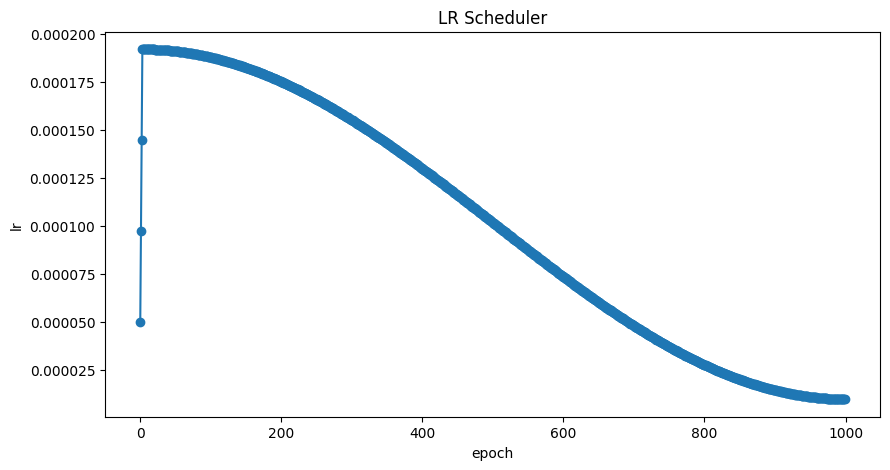

In [117]:
def get_lr_callback(batch_size=CFG.batch_size, mode='cos', epochs=CFG.epochs, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

get_lr_callback(plot=True)

## Avoid Re-Training on Failure
To ensure efficient use of training time and resources, especially in environments with limited hardware capabilities like restricted memory or processing speed, we implemented helper functions to manage model training continuity. This is particularly useful when using TensorFlow with platforms that may have issues that build up over the course of training, such as memory leaks with TensorFlow-Metal on Mac. We can use these methods to resume training from whatever backbone/hyperparameter configuration we left off on when training/testing multiple.

### Methods:
- `load_existing_results`: Reads a CSV with recorded final results from training several models with different hyperparameters and backbone networks
- `is_model_config_trained`: Checks a row from the existing final results and sees if it matches a certain backbone/hyperparameter configuration

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gc

def load_existing_results(results_path):
    try:
        results_df = pd.read_csv(results_path)
        return results_df.to_dict('records')  # Convert DataFrame to list of dicts
    except FileNotFoundError:
        return []  # If the file does not exist, start with an empty list

def is_model_config_trained(existing_results, bb, fb, aug, lr):
    for res in existing_results:
        if res['BackBone'] == bb:
            if res['FreezeBase'] == fb:
                if res['Augment'] == aug:
                    if res['LearningRate'] == lr:
                        return True
    return False

# Load the existing results
results_list = load_existing_results('results/Results.csv')

## Full Hyperparameter Tuning Loop
To optimize our model's performance, we systematically test a range of backbones and configurations using a nested loop structure. This method allows us to evaluate different combinations of backbones, whether to freeze the base model, the use of data augmentation, and various learning rates.

### Tested Hyperparameters
- **Backbones**: A variety of pre-trained networks such as 'ResNet50', 'MobileNetV3Small', 'EfficientNetV2S', 'EfficientNetB3', and 'VGG16'
- **Freeze Base**: Boolean values to decide whether the base layers of the backbone should be trainable or not
- **Augment**: Boolean values to toggle the use of augmentation in the training data
- **Learning Rates**: Fixed values and dynamic callbacks, including '0.01', '0.001', '0.0001', '0.00001', and customized learning rate schedules (`lr_callback` and `lr_callback_all`)

### Training and Validation
For each configuration:
1. The session is reset to clear any existing TensorFlow graph.
1. The existing results CSV is checked to see if the configuration has already been tested.
1. Datasets for training are prepared with specified augmentation and caching options.
1. The model is initialized with the specified backbone and weight freezing.
1. Set up the early stopping and checkpoint callbacks for training based on validation loss.
1. The model is compiled with Adam optimizer and KL Divergence loss, and metrics like accuracy, precision, and recall are set up.
1. Training is conducted.
1. The model is evaluated on the training dataset, the validation dataset, and the test dataset.
    - The performance metrics are loss (kl-divergence), accuracy, precision, and recall
1. The evaluation results are stored in a CSV file (checked in step 2).


In [ ]:
backbone = ['ResNet50', 'MobileNetV3Small', 'EfficientNetV2S', 'EfficientNetB3', 'VGG16']
freeze_base = [True, False]
augment = [True, False]
learning_rate = ['0.01', '0.001', '0.0001', '0.00001', 'lr_callback', 'lr_callback_all']
    
for fb in freeze_base:
    for bb in backbone:
        for aug in augment:
            for lr in learning_rate:

                tf.keras.backend.clear_session()
                
                print(f'{bb=} {fb=} {aug=} {lr=}')

                # Check if this configuration has been trained before
                if is_model_config_trained(results_list, bb, fb, aug, lr):
                    print(f"Skipping already trained configuration: {bb}, {fb}, {aug}, {lr}")
                    continue

                train_ds = build_dataset(train_paths, train_offsets, train_labels, batch_size=CFG.batch_size,
                                         repeat=True, shuffle=1024, augment=aug, cache=True, cache_dir='cache_train/')

                # Model re-initialized here for each learning rate
                model = build_transfer_model(backbone=bb,
                                             input_shape=CFG.image_size + [3],
                                             num_classes=CFG.num_classes,
                                             freeze_base=fb)


                if not os.path.exists("weights"): os.makedirs("weights")
                callbacks = [
                    EarlyStopping(patience=100, verbose=1, monitor='val_loss', mode='min', restore_best_weights=True),
                    ModelCheckpoint(f'weights/{bb}.{fb}.{aug}.{lr}.keras', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
                ]
                
                if str(lr).startswith('lr_callback'):
                    optimizer=tf.keras.optimizers.Adam()
                    callbacks.append(get_lr_callback(batch_size=CFG.batch_size, mode='cos', epochs=CFG.epochs))
                else:
                    optimizer = tf.keras.optimizers.Adam(learning_rate=float(lr))
                    
                model.compile(optimizer=optimizer,
                              loss=tf.keras.losses.KLDivergence(),
                              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

                if os.path.exists(f'weights/{bb}.{fb}.{aug}.{lr}.keras'):
                    print(f'Loading Model weights from: weights/{bb}.{fb}.{aug}.{lr}.keras')
                    #model = load_model(f'weights/{bb}.{fb}.{aug}.{lr}.keras')
                    model.load_weights(f'weights/{bb}.{fb}.{aug}.{lr}.keras')

                history = model.fit(
                    train_ds,
                    validation_data=valid_ds,
                    batch_size=CFG.batch_size,
                    epochs=CFG.epochs,
                    callbacks=callbacks,
                    shuffle=True,
                    steps_per_epoch=train_steps, 
                    validation_steps=valid_steps
                )

                model.load_weights(f'weights/{bb}.{fb}.{aug}.{lr}.keras')

                train_loss, train_accuracy, train_precision, train_recall = model.evaluate(train_ds, steps=train_steps)
                val_loss, val_accuracy, val_precision, val_recall = model.evaluate(valid_ds, steps=valid_steps)
                test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds, steps=test_steps)

                del model
                del train_ds
                del history
                gc.collect()

                results_list.append({
                    'BackBone': bb,
                    'FreezeBase': fb,
                    'Augment': aug,
                    'LearningRate': lr,
                    'TrainLoss': train_loss,
                    'TrainAccuracy': train_accuracy,
                    'TrainPrecision': train_precision,
                    'TrainRecall': train_recall,
                    'ValidLoss': val_loss,
                    'ValidAccuracy': val_accuracy,
                    'ValidPrecision': val_precision,
                    'ValidRecall': val_recall,
                    'TestLoss': test_loss,
                    'TestAccuracy': test_accuracy,
                    'TestPrecision': test_precision,
                    'TestRecall': test_recall,
                })

                if not os.path.exists("results"): os.makedirs("results")
                
                # Save results each iteration so we can check progress
                results_df = pd.DataFrame(results_list)
                results_df.to_csv('results/Results.csv', index=False)
                results_df.to_csv(f'results/{bb}.{fb}.{aug}.{lr}.csv', index=False)
                print(results_df)

## Evaluation of Hyperparameter Tuning Results

### Training Data Augmentation
- Augmenting the training data generally resulted in higher loss values and lower accuracy, precision, and recall.
- This likely indicates that the approach to augmentation was flawed in some way.

### Learning Rate
- Models trained with lower learning rates generally achieved higher accuracy and lower loss both validation and test datasets compared to higher rates. However, the smallest learning rate of 0.00001 did not appear to converge fast enough to continue this trend with the number of epochs, leading to generally higher loss and lower accuracy.
- The use of a dynamic learning rate (`lr_callback`) notably improved performance, yielding the best overall results in each metric as compared to static learning rates.

### Backbone Network
- From initial testing using 100 epochs for training and a cutoff patience of 7 or 10 epochs, using VGG16 or EfficientNetV2S as the backbone seemed to have the best results overall with the right hyperparameters, while MobileNetV3Small and ResNet50 had the worst results overall.

### Freezing the Backbone Weights
- All tests were performed with the backbone frozen due to the large time and resource requirements when training without freezing the backbone network weights.

In [3]:
results_df = pd.read_csv('results/Results.csv')
results_df

BackBone FreezeBase Augment     LearningRate  Epochs  BatchSize  \
0          BaseLine      False    True             0.01   100.0       32.0   
1          BaseLine      False    True            0.001   100.0       32.0   
2          BaseLine      False    True           0.0001   100.0       32.0   
3          BaseLine      False    True          0.00001   100.0       32.0   
4          BaseLine      False    True      lr_callback   100.0       32.0   
5          BaseLine      False   False             0.01   100.0       32.0   
6          BaseLine      False   False            0.001   100.0       32.0   
7          BaseLine      False   False           0.0001   100.0       32.0   
8          BaseLine      False   False          0.00001   100.0       32.0   
9          BaseLine      False   False      lr_callback   100.0       32.0   
10         ResNet50       True    True             0.01   100.0       32.0   
11         ResNet50       True    True            0.001   100.0       32.0   
12         ResNet50       True    True           0.0001   100.0       32.0   
13         ResNet50       True    True          0.00001   100.0       32.0   
14         ResNet50       True    True      lr_callback   100.0       32.0   
15         ResNet50       True    True  lr_callback_all   100.0       32.0   
16         ResNet50       True   False             0.01   100.0       32.0   
17         ResNet50       True   False            0.001   100.0       32.0   
18         ResNet50       True   False           0.0001   100.0       32.0   
19         ResNet50       True   False          0.00001   100.0       32.0   
20         ResNet50       True   False      lr_callback   100.0       32.0   
21         ResNet50       True   False  lr_callback_all   100.0       32.0   
22            VGG16       True    True             0.01   100.0       32.0   
23            VGG16       True    True            0.001   100.0       32.0   
24            VGG16       True    True           0.0001   100.0       32.0   
25            VGG16       True    True          0.00001   100.0       32.0   
26            VGG16       True   False             0.01   100.0       32.0   
27            VGG16       True   False            0.001   100.0       32.0   
28            VGG16       True   False           0.0001   100.0       32.0   
29            VGG16       True   False           0.0001   100.0       32.0   
30            VGG16       True   False          0.00001   100.0       32.0   
31            VGG16       True   False      lr_callback  1000.0       32.0   
32            VGG16       True   False      lr_callback   350.0       32.0   
33  EfficientNetV2S       True    True             0.01   100.0       32.0   
34  EfficientNetV2S       True    True            0.001   100.0       32.0   
35  EfficientNetV2S       True    True            0.001  1000.0       32.0   
36  EfficientNetV2S       True    True           0.0001   100.0       32.0   
37  EfficientNetV2S       True    True          0.00001   100.0       32.0   
38  EfficientNetV2S       True    True      lr_callback   100.0       32.0   
39  EfficientNetV2S       True    True      lr_callback  1000.0       32.0   
40  EfficientNetV2S       True    True  lr_callback_all   100.0       32.0   
41  EfficientNetV2S       True   False             0.01   100.0       32.0   
42  EfficientNetV2S       True   False            0.001   100.0       32.0   
43  EfficientNetV2S       True   False            0.001  1000.0       32.0   
44  EfficientNetV2S       True   False           0.0001   100.0       32.0   
45  EfficientNetV2S       True   False           0.0001  1000.0       32.0   
46  EfficientNetV2S       True   False          0.00001   100.0       32.0   
47  EfficientNetV2S       True   False      lr_callback   100.0       32.0   
48         Ensemble        NaN     NaN              NaN     NaN        NaN   

    Patience  TrainLoss  TrainAccuracy  TrainPrecision  TrainRecall  \
0       10.0     1.1748         0.4704 

## Ensemble Model
We wanted to see if utilizing several of our trained models in an ensemble would lead to improved overall classification performance due to the strengths of these models.

### Identifying Best Configurations
To attempt to harness the collective strengths of the various backbone networks, we implemented a method `get_best_models` to identify the best performing configurations across each different neural network architecture. The method iterates over a list of specified backbones (e.g., 'ResNet50', 'VGG16', 'EfficientNetV2S', 'BaseLine'). For each backbone, it finds the configuration with the lowest validation loss from the results CSV. These configurations are collected in a DataFrame `best_models_df`.

In [72]:
def get_best_models(backbones=[]):
    best_models = []
    for backbone in backbones:
        backbone_data = results_df[results_df['BackBone'] == backbone]
        best_model = backbone_data.loc[backbone_data['ValidLoss'].idxmin()]
        best_models.append(best_model)

    # Return the best models as a new DataFrame
    return pd.DataFrame(best_models)

best_models_df = get_best_models(backbones=['ResNet50', 'VGG16', 'EfficientNetV2S', 'BaseLine'])
best_models_df

BackBone  FreezeBase  Augment LearningRate  Epochs  BatchSize  \
10         ResNet50        True    False  lr_callback     100         32   
21            VGG16        True    False  lr_callback    1000         32   
29  EfficientNetV2S        True     True  lr_callback    1000         32   
58         BaseLine        True     True        0.001     100         32   

    Patience  TrainLoss  TrainAccuracy  TrainPrecision  TrainRecall  \
10        10   1.003637       0.653155        0.887463     0.331470   
21       100   1.161200       0.549600        0.750200     0.337600   
29       100   1.204152       0.461783        0.936803     0.071698   
58        10   1.102783       0.511182        0.764304     0.257888   

    ValidLoss  ValidAccuracy  ValidPrecision        ValidRecall  TestLoss  \
10   1.125996       0.588376        0.827303  0.300358265638351  1.160964   
21   1.057800       0.628000        0.872000           0.0.3296  0.000000   
29   1.280854       0.522547        0.896104        0.150118664  1.296822   
58   1.097730       0.567277        0.718091  0.413216561079025  1.112193   

    TestAccuracy  TestPrecision  TestRecall  
10      0.563694       0.813668    0.277269  
21      0.000000       0.000000    0.000000  
29      0.511669       0.867946    0.152097  
58      0.565884       0.712228    0.403463

## Ensemble Model Predictions
For each best configuration identified in `best_models_df`:
1. A transfer model was built with the specified backbone
1. The weights from the hyperparameter tuning loop training were loaded into the model
1. Predictions were made using the model on the training, validation, and test datasets
1. The list of predictions for each dataset was appended as a row to a 2D array containing predictions from each configuration for that dataset

Once these predictions were complete, the mean of the predictions for each example in each dataset were found and stored as the ensemble model predictions.

In [77]:
train_predictions, valid_predictions, test_predictions = [], [], []

for index, model_config in best_models_df.iterrows():
    bb = model_config['BackBone']
    fb = model_config['FreezeBase']
    aug = model_config['Augment']
    lr = model_config['LearningRate']


    model = build_transfer_model(backbone=bb,
                                 input_shape=CFG.image_size + [3],
                                 num_classes=CFG.num_classes,
                                 freeze_base=fb)

    
    file_path = f'weights/{bb}.{fb}.{aug}.{lr}.keras'
    model.load_weights(f'weights/{bb}.{fb}.{aug}.{lr}.keras')
    print(f"Model loaded from {file_path}")

    train_preds = model.predict(train_ds, steps=train_steps)
    valid_preds = model.predict(valid_ds, steps=valid_steps)
    test_preds = model.predict(test_ds, steps=test_steps)

    # Store predictions
    train_predictions.append(train_preds)
    valid_predictions.append(valid_preds)
    test_predictions.append(test_preds)

ensemble_train_preds = np.mean(train_predictions, axis=0)
ensemble_valid_preds = np.mean(valid_predictions, axis=0)
ensemble_test_preds = np.mean(test_predictions, axis=0)

Model loaded from weights/ResNet50.True.False.lr_callback.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 121s 377ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 377ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 59s 377ms/step
Model loaded from weights/VGG16.True.False.lr_callback.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 539ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 540ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 84s 541ms/step
Model loaded from weights/EfficientNetV2S.True.True.lr_callback.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 141s 431ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 430ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 68s 432ms/step
Model loaded from weights/BaseLine.True.True.0.001.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step


## Ensemble Model Evaluation
For the set of ensemble predictions with each dataset, the same metrics from the hyperparameter tuning loop were calculated.

In [95]:
def extract_labels(dataset, num_batches):
    labels = []
    for features, label in dataset.take(num_batches):
        labels.append(label.numpy()) 
    return np.concatenate(labels)

train_labels = extract_labels(train_ds, train_steps)
valid_labels = extract_labels(valid_ds, valid_steps)
test_labels = extract_labels(test_ds, test_steps)


# Initialize metric objects
kl_divergence = tf.keras.losses.KLDivergence()
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

# Function to calculate metrics
def calculate_metrics(true_labels, predictions):
    # Calculate KLDivergence
    loss = kl_divergence(true_labels, predictions).numpy()

    # Update state for each metric
    accuracy.update_state(np.argmax(true_labels, axis=1), np.argmax(predictions, axis=1))
    precision.update_state(true_labels, predictions)
    recall.update_state(true_labels, predictions)

    # Retrieve result for each metric
    acc_result = accuracy.result().numpy()
    prec_result = precision.result().numpy()
    rec_result = recall.result().numpy()

    # Reset metrics after each calculation
    accuracy.reset_state()
    precision.reset_state()
    recall.reset_state()

    return loss, acc_result, prec_result, rec_result

## Ensemble Model Results
- **Loss**: The ensemble model exhibits higher loss (1.101 validation) compared to the best individual models (1.058 validation, VGG16 backbone). It performs about the average of the models we used to generate the outputs.
- **Accuracy, Precision, and Recall**: The ensemble model underperforms in these metrics on the training set (0.1681 accuracy, 0.1647 precision, 0.0056 recall) when compared to the best-performing single models (0.5496 accuracy, 0.7502 precision, 0.3376 recall, VGG16 backbone).

### Conclusion:
The ensemble model does not perform better than the best single model. The ensemble model has high accuracy and precision, it greatly lacks good performance on recall. We could not recommend using this ensemble model over our best performing single model.

In [96]:
# Evaluate ensemble predictions
train_loss, train_acc, train_prec, train_rec = calculate_metrics(train_labels, ensemble_train_preds)
valid_loss, valid_acc, valid_prec, valid_rec = calculate_metrics(valid_labels, ensemble_valid_preds)
test_loss, test_acc, test_prec, test_rec = calculate_metrics(test_labels, ensemble_test_preds)

print("Train Metrics:", train_loss, train_acc, train_prec, train_rec)
print("Valid Metrics:", valid_loss, valid_acc, valid_prec, valid_rec)
print("Test Metrics:", test_loss, test_acc, test_prec, test_rec)

Train Metrics: 1.9402881 0.168131 0.16470589 0.0055910544
Valid Metrics: 1.101262 0.6683917 0.93188626 0.24781051
Test Metrics: 1.1160127 0.66401273 0.9296754 0.23945063


## Reflections on Project Improvements and Missed Opportunities

### Could Have Done
- **Enhanced Data Augmentation**: More advanced data augmentation techniques such as geometric transformations, color augmentation, and synthetic data generation might have provided more varied training examples.
- **Deeper Hyperparameter Tuning**: We could have conducted a more exhaustive search across a broader range of hyperparameters, such as other learning rate schedules, dropout rates, and the number of layers in neural networks.

### Should Have Done
- **Regularization Techniques**: Implementing additional regularization strategies such as L1/L2 regularization is a common method in the newest state of the art models. These methods are meant to help combate overfitting.
- **Ensemble Method Diversity**: With more time we could have assigned weighted values to each model depending on its strengths.

### Did Not Have Time to Do
- **Feature Engineering**: With more time we could have looked at feature engineering to find out what time frames and where each of the classes occur on the images. We could have cut the images in a specific area to center the defect.
- **Exploring Alternative Loss Functions**: We did not have time to experiment with different loss functions like Focal Loss for addressing class imbalance.

### Resource Limitations and Considerations
- **Lack of Powerful GPUs**: Our team did not have access to powerful NVIDIA GPUs, which significantly restricted our ability to train models. This limitation impacted our ability to experiment with more computationally intensive models and training procedures.
- **Backbone Training**: Due to limited computational resources, we could not experiment with training models with the backbone unfrozen. Freezing the backbone layers helped manage resource use but potentially limited the depth of learning.
- **Variability in Weight Initializers and Seeds**: We could have experimented with different weight initializers and seeds because we were constrained by the lengthy training times.
- **Batch Size Variations**: Exploring different batch sizes could have optimized training efficiency however, larger batch sizes were not feasible due to GPU memory limitations.

## Conclusion
Reflecting on these points emphasizes the importance of resource allocation. Future projects could benefit from securing access to better computational resources or utilizing cloud-based platforms to overcome hardware limitations. Prioritizing these unexplored areas could further enhance the efficacy and applicability of our solutions in neurocritical care and related fields.